# K-means Analysis

This project focuses on the implementation and evaluation of the k-means algorithm. It also includes an implementation of PCA to reduce dimensionality during preprocessing. The constructed algorithms are tested on two data sets. The first data set is gene expression data from cancer patients. The second is response data from an online version of the Depression and Anxiety Stress Scales (DASS). The algorithm's results are evaluated by plotting the clusters. The [GitHub repository](https://github.com/rhynerj/k_means_project) for this project includes as a Python file that can be run from the command line.

##### Imports

In [3]:
import tarfile
import zipfile
import urllib
import urllib.request
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import random
import argparse

### Data Retrieval and Cleaning

##### Download data from online repositories

In [4]:
# retrieval function
# downloads and unpacks a dataset
# takes in url, archive, folder type
def dataset_retrieve(url, archive, f_type) :

    # url for downloading, from given url and archive
    download_url = urllib.parse.urljoin(url, archive)

    # download the archive
    r = urllib.request.urlretrieve (download_url, archive)

    if f_type == "tar" :
        # unzip the archive
        with tarfile.open(archive, 'r:gz') as opened_archive :
             opened_archive.extractall()
    elif f_type == "zip" :
        # unzip the archive
        with zipfile.ZipFile(archive, 'r') as opened_archive :
             opened_archive.extractall()

##### Gene Expression Cancer RNA-Seq Dataset

* *Link:* [https://archive.ics.uci.edu/ml/machine-learning-databases/00401/](https://archive.ics.uci.edu/ml/machine-learning-databases/00401/)
* *Description:* The dataset is comprised of a random extraction of gene expressions of patients with different types of tumors. The tumor types are: BRCA, KIRC, COAD, LUAD and PRAD. Each row represents a sample. RNA-Seq gene expression levels are represented as columns. A separate CSV file reveals the type of cancer associated with each sample.
* *Portion used:* Due to the very high dimensionality of this dataset (20531 attributes), only the first 350 were included in testing.

In [6]:
# download and unpack the gene expression dataset as an array
# set variables
gene_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
gene_archive = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# download gene expression archive files and extract data
dataset_retrieve(gene_url, gene_archive, "tar")

In [6]:
# transform gene data into a numpy array
gene_data_file = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
gene_delim = ","
gene_upper_range = 350
gene_data_array = np.genfromtxt(gene_data_file, delimiter=gene_delim, usecols=range(1, gene_upper_range), skip_header=1)

##### Depression and Anxiety Stress Scales Dataset

* *Source:* [https://openpsychometrics.org/_rawdata/](https://openpsychometrics.org/_rawdata/)
* *Description:* This dataset is made up of answers to an online version of the Depression Anxiety Stress Scales (DASS). Answers are given as a numerical value indicating position on a subjective scale from 1 to 4. Time spent on the landing page, the DASS questions, and the other demographic/survey questions was also recorded. The following generic demographic survey information is also included: Ten Item Personality Inventory scores (scale of 1 to 7), English vocabulary (1 for yes or 0 for no to indicate whether participants knew the definition of a word), and numerical codes for education level, childhood environment (e.g. urban), gender, whether native language is English, age, handedness, religion, sexual orientation, race, voting habits, marital status, and family size. College major is included as a write-in option. Finally, technical information was used to determine country, screen size, uniqueness of location, and source.
* *Portion used:* All data for DASS questions (question answer, time taken to answer the question, and question position in survey) was included. Non-DASS data was excluded due to sparsity.

In [24]:
# downloads and unpacks the dass dataset as an array
# set variables
 # set variables
dass_url = "https://openpsychometrics.org/_rawdata/"
dass_archive = "DASS_data_21.02.19.zip"

# download DASS file and extract data
dataset_retrieve(dass_url, dass_archive, "zip")

In [5]:
# transform dass data into a numpy array
dass_data_file = "/home/jrhyner/Documents/CS2810/final_project/DASS_data_21.02.19/data.csv"
dass_delim = "\t"
dass_upper_range = 127 # 3 measurements for 42 questions -> 126
dass_data_array = np.genfromtxt(dass_data_file, delimiter=dass_delim, usecols=range(1, dass_upper_range), skip_header=1, dtype=int)

##### Minmaxscaling

In [7]:
# normalizes given data using minmax scaling
# takes in np array
# modeled after MinMaxScaler() in sklearn
def min_max_scale(data) :
    # min and max values of data
    data_max = np.max(data)
    data_min = np.min(data)

    # use min and max to scale data
    scaled_data = np.array([(x - data_min) / (data_max - data_min) for x in data])

    return scaled_data

##### Principle Component Analysis

In [8]:
# PCA: reduces the number of dimensions in the dataset
# isolates the most variable components
# takes in a dataset and a number of dimensions
def pca(X, num_components) :
    # subtract the mean of each variable to mean center data
    X_meaned = X - np.mean(X , axis = 0)

    # calculate covariance matrix (of meaned_data)
    cov_mat = np.cov(X_meaned , rowvar = False)

    # calculate eigenvalues and -vectors from covariance matrix
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    # sort eigenvals and vects, accoring to descending eigenval
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]

    # get top n of eigenvects
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]

    # transform data into reduced form
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced

##### Preprocessing

In [9]:
# calls preprocessing steps on given data array
# also takes in number of components, num_components, for PCA
# returns processed data
def preprocess(data, num_components) :
    # scale data
    scaled_data = min_max_scale(data)

    # use PCA to reduce dimensions
    reduced_data = pca(scaled_data, num_components)

    # return preprocessed data
    return reduced_data

##### Data Cleaning

In [10]:
# get the given data array and preprocess it
# also takes in number of components for pca
# returns pre-processed data
def cleaned_data(dataset, pca_components) :
    dataset = dataset.lower()
    # get data array
    if dataset == 'gene' :
        data_array = gene_data_array
    elif dataset == 'dass' :
        data_array = dass_data_array
    # preprocess: scale data and run pca
    preprocessed_data = preprocess(data_array, pca_components)
    return preprocessed_data

### K-means

In [11]:
# k-means class
class k_means :
    # init -> default max_loops is 100
    def __init__(self, k, max_loop=100) :
        self.k = k
        self.max_loop = max_loop

    # runs k_means (based on sklearn fit())
    def fit(self, data) :
        # initialize centroids
        self.centroids = self.init_centroids(data)
        # loop until reached max or centroids stop changing
        looped = 0
        same = False # centroids same as last time?
        while looped < self.max_loop and not same :
            # centroids at start of loop (from init or past loop)
            start_centroids = self.centroids
            distances = self.data_centroid_dists(data, start_centroids)
            # sort into clusters
            self.clusters = self.closest_dists(distances)
            # update centroids
            self.centroids = self.update_centroids(data, self.clusters)
            # update conditions
            same = np.array_equal(start_centroids, self.centroids)
            looped += 1
        # compute cluster stats
        self.sse = self.inertia(data, self.clusters, self.centroids)
        self.csizes = self.cluster_sizes(data)
        

    # initialize centroids
    def init_centroids(self, data) :
        num_rows = data.shape[0]
        # randomly select k indices
        rand_indices = np.random.choice(num_rows, size=self.k, replace=False)
        # select k random rows from data 
        centroids_arr = data[rand_indices, :]
        # set centroids
        self.centroids = centroids_arr
        return self.centroids
    
    # update centroids to be mean of data points
    def update_centroids(self, data, clusters) :
        # centroids array
        centroids_arr = np.zeros((self.k, data.shape[1]))
        for i in range(self.k) :
            # set centroid k to mean
            centroids_arr[i, :] = np.mean(data[clusters == i, :], axis=0)
        return centroids_arr
    
    # takes in a distance array and returns minimums
    def closest_dists(self, distance_arr) :
        return np.argmin(distance_arr, axis=1)
    
    # calculates the distance from each data point to each centroid
    def data_centroid_dists(self, data, centroid_arr) :
        # array of distances
        distance_arr = np.zeros((data.shape[0], self.k))
        for i in range(self.k) :
            # calculate norm of data - centroids
            dp_norm = np.linalg.norm(data - centroid_arr[i, :], axis=1)
            # insert square dist
            distance_arr[:, i] = np.square(dp_norm)
        # return results array
        return distance_arr

    # Cluster Stats

    # finds sizes of each cluster
    def cluster_sizes(self, data) :
        # size array
        size_arr = np.zeros((self.k))
        # all clusters
        clusters = self.clusters
        for i in range(self.k) :
            cluster_points = data[clusters == i]
            cluster_size = cluster_points.shape[0]
            size_arr[i] = cluster_size
        return size_arr


    # SSE
    # find inertia (sse)
    def inertia(self, data, clusters, centroids_arr) :
        # distances array
        dists_arr = np.zeros(data.shape[0])
        for i in range(self.k) :
            # clusterwise dists from centroid
            dists_arr[clusters == i] = np.linalg.norm(data[clusters == i] - centroids_arr[i], axis=1)
        # compute sse
        sse = np.sum(np.square(dists_arr))
        return sse

### Evaluation and Visualization

##### Elbow Curve

In [12]:
# runs k-means with a given range of ks, calculates inertia (sse) for each
# takes in data, max_k, max_loop
# where max_k is the upperbound of ks to test
# returns sses as k:sse dict
def k_range_inertias(data, max_k, max_lp) :
    # ks
    k_list = list(range(1, max_k))
    # sses
    sse_list = []
    # for each k in range, find inertia (sse) and add to list
    for n in k_list :
        km = k_means(k=n, max_loop=max_lp)
        km.fit(data)
        sse_list.append(km.sse)
    return [k_list, sse_list]

In [13]:
# finds sses for range of k up to max k
# takes in data, max_k, max_loop
def elbow_plot(data, max_k, max_loop) :
    # find k_range_inertias
        inertia_list = k_range_inertias(data, max_k, max_loop)
        # extract ks for x-axis
        k_vals = inertia_list[0]
        # extract sses for y-axis
        sses = inertia_list[1]
        # plot sse over k
        plt.figure(figsize=(6, 6))
        plt.plot(k_vals, sses, '-o')
        plt.xlabel(r"Number of clusters *k*")
        plt.ylabel("Inertia (SSE)")
        # display results
        plt.show()

##### Cluster Plotting

In [14]:
# randomly generate an n-length list of unique colors as rgb values
def rand_colors(n) :
    colors = []
    while len(colors) < n :
        color= "#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
        if color not in colors :
            colors.append(color)
    return colors

In [15]:
# plots all clusters and their centroids with sizes
# takes in data retrieval function, k, and max_loop and forces pca to 2 to allow plotting
# also takes in x and y labels and title
def plot_clusters(data_fn, k_val, max_lp, x_label, y_label, title) :
    # clean data
    data = cleaned_data(data_fn, 2)
    # run k means
    km = k_means(k_val, max_lp)
    km.fit(data)
    # get centroids
    centroids = km.centroids
    # get sse
    sse = km.sse
    # generate list of colors for k clusters and centroid
    colors = rand_colors(k_val + 1)
    # plot data and centroids
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(0, k_val) :
        color = colors[i]
        cluster_label = 'cluster ' + str(i + 1) + ': size = ' + str(km.csizes[i])
        plt.scatter(data[km.clusters == i, 0], data[km.clusters == i, 1], c=color, label=cluster_label)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300, c=colors[-1], label='centroid')
    plt.legend()
    plt.figtext(0.02, 0.02, 'sse = ' + str(sse), fontsize = 10)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    ax.set_aspect('equal')
    plt.show()

### Results

##### Gene Dataset

Graphing inertia values for a range of k values applied to the gene dataset on an elbow curve reveals that the optimal for the dataset when reduced to two principal components is 4, as this is where the curve begins to level off.

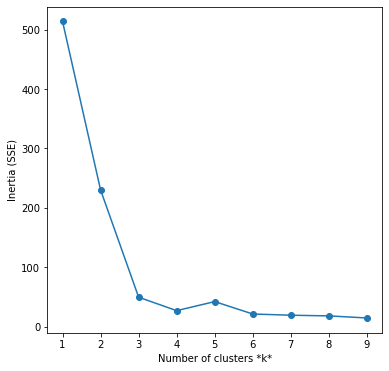

In [16]:
# clean gene data for input and reduce to two principle components
in_data = cleaned_data('gene', 2)
# run the elbow_plot function with the cleaned data, a max_k of 10, and 100 as the max_loop
elbow_plot(in_data, 10, 100)

The inertia values indicate a moderately large data spread. This can be seen when the data is plotted. Most of the points fall into tightly grouped clusters, but each cluster contains regions of lower density near its edges.

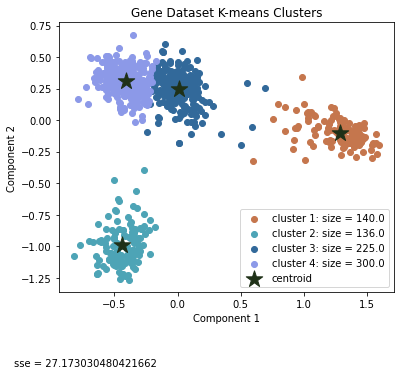

In [26]:
# run the plot_clusters function on the gene dataset with a k of 4 (based on the elbow plot), 100 as the max_loop, and x and y labels and title
plot_clusters('gene', 4, 100, 'Component 1', 'Component 2', 'Gene Dataset K-means Clusters')

The data for this dataset is fairly evenly distributed. Because initial clusters are chosen randomly, there are multiple possible cluster configurations. The lowest SSE of all observed runs is about 27.17. The cluster sizes in this configuration range from 136 to 300. Based on these clusters, PCA dimensionality reduction to to components retained the integrity of the gene dataset.

##### DASS Dataset

Graphing inertia values for a range of k values applied to the DASS dataset on an elbow curve reveals that the optimal for the dataset when reduced to two principal components is 3, as this is where the curve begins to level off (with a k of two, the SSE was measured as less than 0.2).

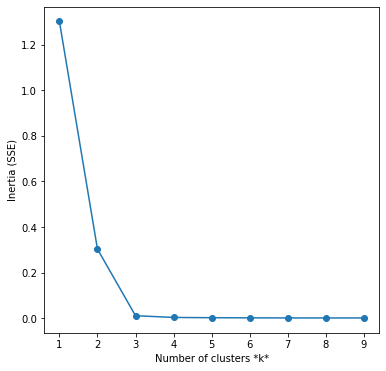

In [18]:
# clean dass data for input and reduce to two principle components
in_data = cleaned_data('dass', 2)
# run the elbow_plot function with the cleaned data, a max_k of 10, and 100 as the max_loop
elbow_plot(in_data, 10, 100)

The intertia values here are low, indicating a small data spread. Plotting the clusters revealed that the spread was not even. Running k-means on the reduced DASS dataset produced three very distinct clusters, but two of them contained only a single data point.

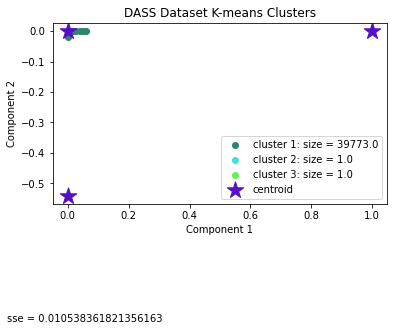

In [29]:
# run the plot_clusters function on the DASS dataset with a k of 3 (based on the elbow plot), 100 as the max_loop, and x and y labels and title
plot_clusters('dass', 3, 100, 'Component 1', 'Component 2', 'DASS Dataset K-means Clusters')

Inertia is consistenly about low at 0.01 across multiple runs, but cluster sizes have a huge range, from 1 to 39,773. Increasing k to 10 does not produce more evenly sized clusters (though it does further reduce SSE).

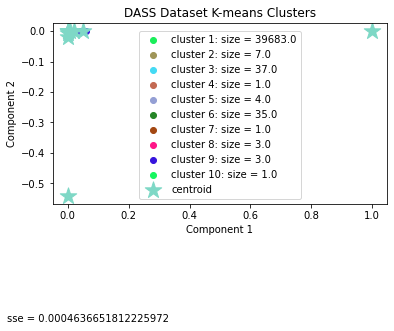

In [20]:
# plotting clusters with k=10
plot_clusters('dass', 10, 100, 'Component 1', 'Component 2', 'DASS Dataset K-means Clusters')

It is likely that the two distant data points are outliers. Further examination of the data might justify eliminating them, or increasing the number of principle components might reduce their effect. However, both of these are outside of the scope of this project, which is focused on evaluating the k-means algorithm.

### Conclusion

K-means is very useful for clustering. However, due to runtime and memory limitations, it can often only be run when the dimensions of the data have been reduced, such as by using PCA. In this case, it was apparent that PCA is better at preserving some datasets than others, and that this affects the success of k-means.

The reduced DASS dataset exposed a common issue with k-means: namely, it struggles with outliers. Even less extreme cases, k-means is less successful when data is not more or less evenly and distinctly clumped. However, it can fairly successfully distinguish between two adjacent clusters. Oddly shaped datasets (especially circular datasets) are not well suited to k-means clustering, but for most datasets that form clump-like clusters, k-means is a relatively simple and effective way to divide data into clusters for analysis.